- Introduction
- Data Load
- Data Preprocessing
- Visualization (Not done yet)
- Model
- Validate (Not done yet (K Fold) Will do in next pass) 
- Test
- Submit
    

## Introduction

While looking for the solution for this problem initially I was going towards NER way to solve it. But after reading different kernals and blog. I could figure out we can perform Q&A approch.

Clap for : This wonder full artical https://www.kaggle.com/jonathanbesomi/question-answering-starter-pack. 
Though I've made my on changes in training model.

### Approach

We have:

- Question: sentiment column (positive or negative), which I've converted into is positive, is negative or is neutral. Just to make it feel like a question. 
- Context: text column
- Answer: selected_text column


#### Note : 
- Please make sure while working on this problem your internet must be off. This is one of requirement on submittion our code base.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/tweet-sentiment-extraction/sample_submission.csv
/kaggle/input/tweet-sentiment-extraction/test.csv
/kaggle/input/tweet-sentiment-extraction/train.csv
/kaggle/input/transformers-pretrained-distilbert/distilbert-base-uncased-distilled-squad/vocab.txt
/kaggle/input/transformers-pretrained-distilbert/distilbert-base-uncased-distilled-squad/pytorch_model.bin
/kaggle/input/transformers-pretrained-distilbert/distilbert-base-uncased-distilled-squad/special_tokens_map.json
/kaggle/input/transformers-pretrained-distilbert/distilbert-base-uncased-distilled-squad/config.json
/kaggle/input/transformers-pretrained-distilbert/distilbert-base-uncased-distilled-squad/tokenizer_config.json
/kaggle/input/simple-transformers-pypi/seqeval-0.0.12-py3-none-any.whl
/kaggle/input/simple-transformers-pypi/simpletransformers-0.22.1-py3-none-any.whl


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data Load

In [3]:
train_df = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')
test_df = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')

In [4]:
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


### Category Distribution

Category disribution is fairly balanced. So one thing is sure in train data we should not borther about data imbalance.

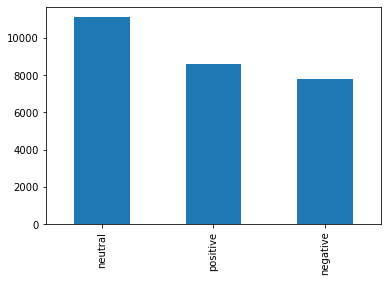

In [6]:
train_df['sentiment'].value_counts().plot(kind='bar')

Same here Category disribution is fairly balanced.

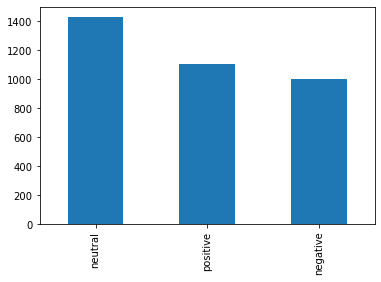

In [7]:
test_df['sentiment'].value_counts().plot(kind='bar')

## Data pre-processing

We have almost no null rows / columns. We can drop them.

In [8]:
train_df.count()

textID           27481
text             27480
selected_text    27480
sentiment        27481
dtype: int64

In [9]:
train_df.dropna(inplace=True)

In [10]:
train_df.count()

textID           27480
text             27480
selected_text    27480
sentiment        27480
dtype: int64

As we following Question Answer approach. We need to convert our train / test data into Q & A accepting format.

In [11]:
def build_train_data(df):
    train_data = []
    for index in df.index:
        context = df.loc[index,'text']
        idx = df.loc[index,'textID']
        que = 'is '+df.loc[index,'sentiment']
        ans = df.loc[index,'selected_text']
        start_pos = df.loc[index,'text'].find(df.loc[index,'selected_text'])
        
        qas = []
        answers = []
        ans_dict = {}
        qa_dict = {}
        ans_dict = {'text': ans,'answer_start':start_pos}
        answers.append(ans_dict)
        qa_dict = {'id':idx,'question': que,'is_impossible':False,'answers':answers}
        qas.append(qa_dict)
        cont_dict ={'context':context,'qas':qas}
        train_data.append(cont_dict)
    return train_data

In [12]:
test_df.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [13]:
def build_test_data(df):
    train_data = []
    for index in df.index:
        context = df.loc[index,'text']
        idx = df.loc[index,'textID']
        que = 'is '+df.loc[index,'sentiment']

        
        qas = []
        answers = []
        ans_dict = {}
        qa_dict = {}
        ans_dict = {'text': '__NONE__','answer_start':9999999}
        answers.append(ans_dict)
        qa_dict = {'id':idx,'question': que,'is_impossible':False,'answers':answers}
        qas.append(qa_dict)
        cont_dict ={'context':context,'qas':qas}
        train_data.append(cont_dict)
    return train_data

In [14]:
distil_accept_train = build_train_data(train_df)

Here is sample converted data in Q & A format. 

In [15]:
distil_accept_train[0:1]

[{'context': ' I`d have responded, if I were going',
  'qas': [{'id': 'cb774db0d1',
    'question': 'is neutral',
    'is_impossible': False,
    'answers': [{'text': 'I`d have responded, if I were going',
      'answer_start': 1}]}]}]

In [16]:
distil_accept_test = build_test_data(test_df)

In [17]:
distil_accept_test[0:1]

[{'context': 'Last session of the day  http://twitpic.com/67ezh',
  'qas': [{'id': 'f87dea47db',
    'question': 'is neutral',
    'is_impossible': False,
    'answers': [{'text': '__NONE__', 'answer_start': 9999999}]}]}]

export converted data into json is optional.

## Model Traninig

In [18]:
!pip install '/kaggle/input/simple-transformers-pypi/seqeval-0.0.12-py3-none-any.whl' -q

In [19]:
!pip install '/kaggle/input/simple-transformers-pypi/simpletransformers-0.22.1-py3-none-any.whl' -q

In [20]:
from simpletransformers.question_answering import QuestionAnsweringModel

This is pre-trained model (DistilBert + Squad). You can download it for offline use.
https://www.kaggle.com/jonathanbesomi/transformers-pretrained-distilbert.

In [21]:
model_path = '/kaggle/input/transformers-pretrained-distilbert/distilbert-base-uncased-distilled-squad'

In [22]:
%%time

model = QuestionAnsweringModel('distilbert',model_path,args={'reprocess_input_data': True,
                                     'overwrite_output_dir': True,
                                     'train_batch_size': 32,                        
                                     'learning_rate': 5e-5,
                                     'num_train_epochs': 4,
                                     'max_seq_length': 192,
                                     'doc_stride': 64,
                                     'fp16': False,                      
                                    },use_cuda=True)

CPU times: user 1.24 s, sys: 629 ms, total: 1.87 s
Wall time: 2.04 s


In [23]:
%%time
model.train_model(distil_accept_train)

100%|██████████| 27480/27480 [00:39<00:00, 697.22it/s]


Running loss: 2.461670

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 1.076369


Running loss: 0.661271


Running loss: 0.617617

CPU times: user 12min 3s, sys: 6min 6s, total: 18min 10s
Wall time: 18min 16s


In [24]:
pred =  model.predict(distil_accept_test)

100%|██████████| 3534/3534 [00:04<00:00, 843.03it/s]


In [25]:
pred[0:2]

[{'id': 'f87dea47db', 'answer': 'Last session of the day'},
 {'id': '96d74cb729', 'answer': 'really exciting'}]

In [26]:
sub_df = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/sample_submission.csv')

In [27]:
submit_df = pd.DataFrame.from_dict(pred)
sub_df['selected_text'] = submit_df['answer']
sub_df.to_csv('submission.csv',index=False)
print('successfully submit')

successfully submit


In [28]:
# import shutil
# import os

In [29]:
#os.remove('train.json')

In [30]:
#shutil.rmtree('outputs/')